# Phenomenological Synaptic Models

In [1]:
pip install -U brainpy-simulator

     |████████████████████████████████| 126 kB 5.3 MB/s 
  Created wheel for brainpy-simulator: filename=brainpy_simulator-1.0.2-py3-none-any.whl size=152106 sha256=e220e2a0b17ac6ee96cdc587a81a3aa9dfaaeb5bac21f476df371753a08aed0c
  Stored in directory: /root/.cache/pip/wheels/ec/1c/3f/e33093b69bc03ff9b2742480ec6126ddef875ba4f6d3699659
Successfully built brainpy-simulator


In [2]:
import numpy as np
import brainpy as bp

import matplotlib.pyplot as plt

**LIF Neuron**

In [3]:
class LIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(V, t, Iext, V_rest, R, tau):
    dvdt = (-V + V_rest + R * Iext) / tau
    return dvdt

  def __init__(self, size, t_ref=1., V_rest=0., V_reset=0., 
               V_th=20., R=1., tau=10., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)
    
    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_ref = t_ref

    # variables
    self.t_last_spike = bp.ops.ones(self.num) * -1e7
    self.refractory = bp.ops.zeros(self.num, dtype=bool)
    self.spike = bp.ops.zeros(self.num, dtype=bool)
    self.V = bp.ops.ones(self.num) * V_rest
    self.input = bp.ops.zeros(self.num)

  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.t_ref
      if not refractory:
        V = self.integral(self.V[i], _t, self.input[i],
                          self.V_rest, self.R, self.tau)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_reset
          self.t_last_spike[i] = _t
          refractory = True
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory
      self.input[i] = 0.

## Voltage Jump Model

$$
I = \sum_{j\in C} g \delta(t-t_j-D)
$$

where $g$ denotes the chemical synaptic strength, $t_j$ the spiking moment of the presynaptic neuron $j$, $C$ the set of neurons in the encoding layer, and $D$ the transmission delay of chemical synapses. For simplicity, we omit the rise and decay phases of post-synaptic currents. 


In [4]:
class VoltageJump(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, delay=0., post_refractory=False, weight=1., **kwargs):
        # parameters
        self.delay = delay
        self.post_has_refractory = post_refractory

        # connections
        self.conn = conn(pre.size, post.size)
        self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
        self.num = len(self.pre_ids)

        # variables
        self.s = np.zeros(self.num)
        self.w = np.ones(self.num) * weight
        self.I_syn = self.register_constant_delay('I_syn', size=self.num, delay_time=delay)

        super(VoltageJump, self).__init__(pre=pre, post=post, **kwargs)
        
        # checking
        assert hasattr(pre, 'V'), 'Pre-synaptic group must has "V" variable.'
        assert hasattr(post, 'V'), 'Post-synaptic group must has "V" variable.'
        assert hasattr(post, 'input'), 'Post-synaptic group must has "input" variable.'
        if post_refractory:
            assert hasattr(post, 'refractory'), 'Post-synaptic group must has "refractory" variable.'

    def update(self, _t):
        for i in range(self.num):
            pre_id = self.pre_ids[i]
            post_id = self.post_ids[i]
            # update
            self.s[i] = self.pre.spike[pre_id]
            self.I_syn.push(i, self.s[i] * self.w[i])
            # output
            I_syn = self.I_syn.pull(i)
            if self.post_has_refractory:
                self.post.V += I_syn * (1. - self.post.refractory[post_id])
            else:
                self.post.V += I_syn

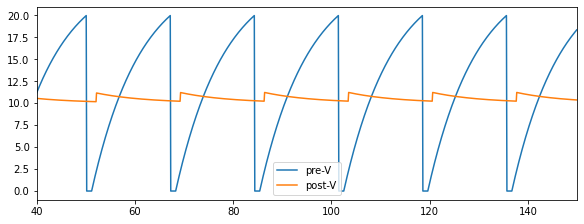

In [5]:
neu1 = LIF(1, monitors=['V', 'spike'])
neu2 = LIF(1, monitors=['V'])

syn1 = VoltageJump(pre=neu1, post=neu2, conn=bp.connect.All2All(), delay=2.0)

net = bp.Network(neu1, syn1, neu2)
net.run(150., inputs=[(neu1, 'input', 25.), (neu2, 'input', 10.)])

fig, gs = bp.visualize.get_figure(1, 1, 3, 8)
plt.plot(net.ts, neu1.mon.V, label='pre-V')
plt.plot(net.ts, neu2.mon.V, label='post-V')
plt.xlim(40, 150)
plt.legend()

## Exponential Model

$$
g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} e^{-\left(t-t_{0}\right) / \tau}
$$

where $\tau$ is the time constant, $t_0$ is the time of the pre-synaptic spike, $\bar{g}_{\mathrm{syn}}$ is the maximal conductance.

The corresponding differential equation:

$$
\tau \frac{d g_{\mathrm{syn}}(t)}{d t}=-g_{\mathrm{syn}}(t)+\bar{g}_{\mathrm{syn}} \delta\left(t_{0}-t\right)
$$

In [8]:
class Exponential(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(s, t, tau):
    ds = -s / tau
    return ds

  def __init__(self, pre, post, conn, delay=0., g_max=1., tau=10.0, **kwargs):
    # parameters
    self.tau = tau
    self.delay = delay

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.num = len(self.pre_ids)

    # variables
    self.g = bp.ops.zeros(self.num)
    self.g_max = g_max
    self.I_syn = self.register_constant_delay('I_syn', size=self.num, delay_time=delay)

    # initialization
    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
    super(Exponential, self).__init__(pre=pre, post=post, **kwargs)

    # checking
    assert hasattr(pre, 'V'), 'Pre-synaptic group must has "V" variable.'
    assert hasattr(post, 'V'), 'Post-synaptic group must has "V" variable.'
    assert hasattr(post, 'input'), 'Post-synaptic group must has "input" variable.'

  def update(self, _t, _i, _dt):
    for i in range(self.num):
      pre_id = self.pre_ids[i]
      post_id = self.post_ids[i]
      # update
      self.g[i] = self.integral(self.g[i], _t, self.tau)
      self.g[i] += self.pre.spike[pre_id] 
      self.I_syn.push(i, self.g_max * self.g[i])
      # output
      self.post.input[post_id] += self.I_syn.pull(i)


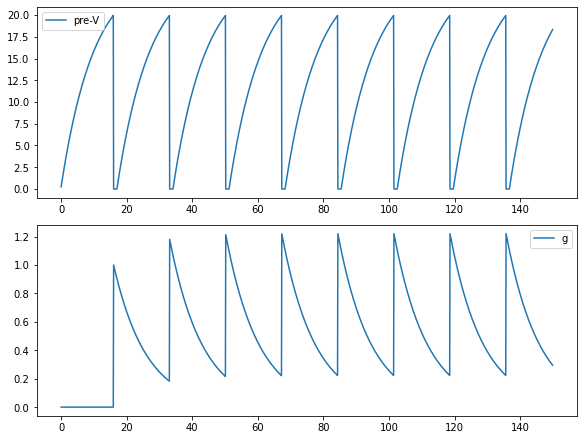

In [9]:
neu1 = LIF(1, monitors=['V'])
neu2 = LIF(1)

syn1 = Exponential(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['g'])

net = bp.Network(neu1, syn1, neu2)
net.run(150., inputs=[(neu1, 'input', 25.), ])

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu1.mon.V, label='pre-V')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn1.mon.g, label='g')
plt.legend()

## Alpha Function Model

$$
g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} \frac{t-t_{0}}{\tau} e^{1-\left(t-t_{0}\right) / \tau}
$$
where $\tau$ is the time constant, $t_0$ is the time of the pre-synaptic spike, $\bar{g}_{\mathrm{syn}}$ is the maximal conductance.

The corresponding differential equation:

$$
\begin{aligned}
&g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} g \\
&\frac{d g}{d t}=-\frac{g}{\tau}+h \\
&\frac{d h}{d t}=-\frac{h}{\tau}+\delta\left(t_{0}-t\right)
\end{aligned}
$$


In [17]:
class Alpha(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(g, h, t, tau):
    dgdt = -g/tau + h
    dhdt = -h/tau
    return dgdt, dhdt

  def __init__(self, pre, post, conn, delay=0., g_max=1., tau=10.0, **kwargs):
    # parameters
    self.tau = tau
    self.delay = delay

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.num = len(self.pre_ids)

    # variables
    self.g = bp.ops.zeros(self.num)
    self.h = bp.ops.zeros(self.num)
    self.g_max = g_max
    self.I_syn = self.register_constant_delay('I_syn', size=self.num, delay_time=delay)

    # initialization
    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
    super(Alpha, self).__init__(pre=pre, post=post, **kwargs)

    # checking
    assert hasattr(pre, 'V'), 'Pre-synaptic group must has "V" variable.'
    assert hasattr(post, 'V'), 'Post-synaptic group must has "V" variable.'
    assert hasattr(post, 'input'), 'Post-synaptic group must has "input" variable.'

  def update(self, _t, _i, _dt):
    for i in range(self.num):
      pre_id = self.pre_ids[i]
      post_id = self.post_ids[i]
      # update
      self.g[i], self.h[i] = self.integral(self.g[i], self.h[i], _t, self.tau)
      # self.g[i] += self.pre.spike[pre_id] # i dont know why without this
      self.h[i] += self.pre.spike[pre_id]
      self.I_syn.push(i, self.g_max * self.g[i])
      # output
      self.post.input[post_id] += self.I_syn.pull(i)
    

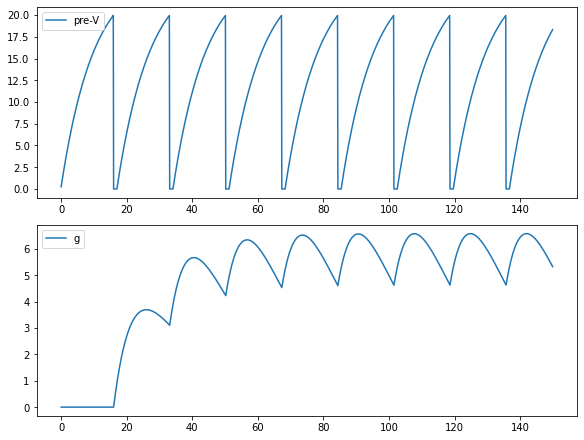

In [18]:
neu1 = LIF(1, monitors=['V'])
neu2 = LIF(1)

syn1 = Alpha(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['g'])

net = bp.Network(neu1, syn1, neu2)
net.run(150., inputs=[(neu1, 'input', 25.), ])

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu1.mon.V, label='pre-V')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn1.mon.g, label='g')
plt.legend()

## Dual Exponential Model

$$
g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} \frac{\tau_{1} \tau_{2}}{\tau_{1}-\tau_{2}}\left(\exp \left(-\frac{t-t_{0}}{\tau_{1}}\right)-\exp \left(-\frac{t-t_{0}}{\tau_{2}}\right)\right)
$$

where $\tau_1$ is the time constant of the decay phase, $\tau_2$ is the time constant of the rise phase, $t_0$ is the time of the pre-synaptic spike, $\bar{g}_{\mathrm{syn}}$ is the maximal conductance.

The corresponding differential equation:

$$
\begin{aligned}
&g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} g \\
&\frac{d g}{d t}=-\frac{g}{\tau_{\mathrm{decay}}}+h \\
&\frac{d h}{d t}=-\frac{h}{\tau_{\text {rise }}}+ \delta\left(t_{0}-t\right),
\end{aligned}
$$

The alpha function is retrieved in the limit when both time constants are equal.

In [19]:
class DualExponential(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(g, h, t, tau_decay, tau_rise):
    dgdt = -g/tau_decay + h
    dhdt = -h/tau_rise
    return dgdt, dhdt

  def __init__(self, pre, post, conn, delay=0., g_max=1., tau_decay=10., tau_rise=1., **kwargs):
    # parameters
    self.tau_decay = tau_decay
    self.tau_rise = tau_rise
    self.delay = delay

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.num = len(self.pre_ids)

    # variables
    self.g = bp.ops.zeros(self.num)
    self.h = bp.ops.zeros(self.num)
    self.g_max = g_max
    self.I_syn = self.register_constant_delay('I_syn', size=self.num, delay_time=delay)

    # initialization
    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
    super(DualExponential, self).__init__(pre=pre, post=post, **kwargs)

    # checking
    assert hasattr(pre, 'V'), 'Pre-synaptic group must has "V" variable.'
    assert hasattr(post, 'V'), 'Post-synaptic group must has "V" variable.'
    assert hasattr(post, 'input'), 'Post-synaptic group must has "input" variable.'

  def update(self, _t, _i, _dt):
    for i in range(self.num):
      pre_id = self.pre_ids[i]
      post_id = self.post_ids[i]

      # update
      self.g[i], self.h[i] = self.integral(self.g[i], self.h[i], _t, self.tau_decay, self.tau_rise)
      self.h[i] += self.pre.spike[pre_id]
      self.I_syn.push(i, self.g_max * self.g[i])

      # output
      self.post.input[post_id] += self.I_syn.pull(i)

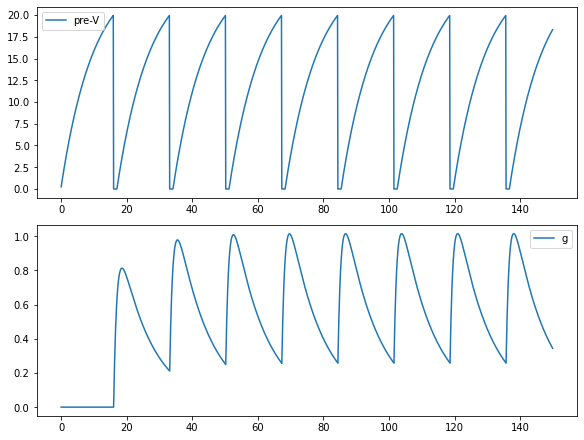

In [20]:
neu1 = LIF(1, monitors=['V'])
neu2 = LIF(1)

syn1 = DualExponential(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['g'])

net = bp.Network(neu1, syn1, neu2)
net.run(150., inputs=[(neu1, 'input', 25.), ])

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu1.mon.V, label='pre-V')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn1.mon.g, label='g')
plt.legend()

## Problem of Phenomenological Synaptic Models

A significant limitation of the simple waveform description of synaptic conductance is that it does not capture the actual behavior seen at many synapses when trains of action potentials arrive. 

A new release of neurotransmitter soon after a previous release should not be expected to contribute as much to the postsynaptic conductance due to saturation of postsynaptic receptors by previously released transmitter and the fact that some receptors will already be open.

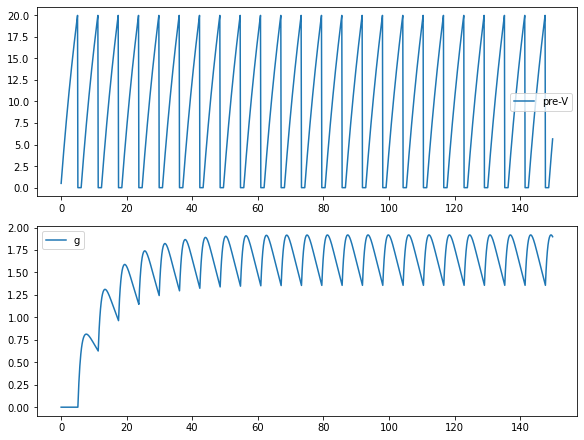

In [21]:
neu1 = LIF(1, monitors=['V'])
neu2 = LIF(1)

syn1 = DualExponential(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['g'])

net = bp.Network(neu1, syn1, neu2)
net.run(150., inputs=[(neu1, 'input', 50.), ])

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu1.mon.V, label='pre-V')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn1.mon.g, label='g')
plt.legend()

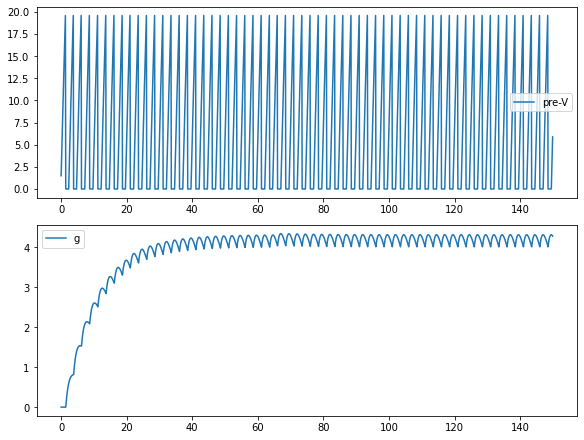

In [22]:
neu1 = LIF(1, monitors=['V'])
neu2 = LIF(1)

syn1 = DualExponential(pre=neu1, post=neu2, conn=bp.connect.All2All(), monitors=['g'])

net = bp.Network(neu1, syn1, neu2)
net.run(150., inputs=[(neu1, 'input', 150.), ])

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu1.mon.V, label='pre-V')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn1.mon.g, label='g')
plt.legend()

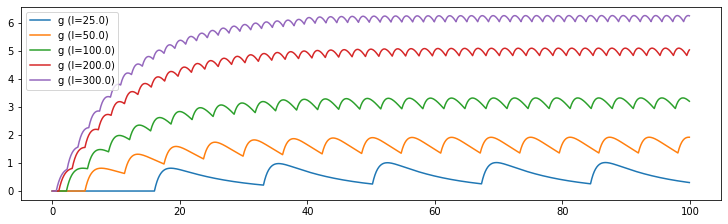

In [23]:
Iext = np.array([25., 50, 100, 200, 300])

neu1 = LIF(len(Iext), monitors=['V', 'spike'])
neu2 = LIF(len(Iext), monitors=['V'])
syn1 = DualExponential(pre=neu1, post=neu2, conn=bp.connect.One2One(), monitors=['g'])
net1 = bp.Network(neu1, syn1, neu2)
net1.run(100., inputs=(neu1, 'input', Iext))

fig, gs = bp.visualize.get_figure(1, 1, 3, 10)
for i in range(Iext.shape[0]):
    plt.plot(syn1.mon.ts, syn1.mon.g[:, i], label=f'g (I={Iext[i]})')
plt.legend()